Using Large Image in Jupyter
============================

The large_image library has some convenience features for use in Jupyter Notebooks and Jupyter Lab.  Different features are available depending on whether your data files are local or on a Girder server.

Installation
------------

The large_image library has a variety of tile sources to support a wide range of file formats.  Many of these depend
on binary libraries.  For linux systems, you can install these from python wheels via the `--find-links` option.  For
other operating systems, you will need to install different libraries depending on what tile sources you wish to use.

In [1]:
# This will install large_image, including all sources and many other options
!pip install large_image[all] --find-links https://girder.github.io/large_image_wheels
# For a smaller set of tile sources, you could also do:
# !pip install large_image[pil,rasterio,tifffile]

# For maximum capabilities in Jupyter, also install ipyleaflet so you can
# view zoomable images in the notebook
!pip install ipyleaflet

# If you are accessing files on a Girder server, it is useful to install girder_client
!pip install girder_client

Looking in links: https://girder.github.io/large_image_wheels


Using Local Files
-----------------

When using large_image with local files, when you open a file, large_image returns a tile source.  See [girder.github.io/large_image](https://girder.github.io/large_image) for documentation on what you can do with this.

First, we download a few files so we can use them locally.

In [2]:
# Get a few files so we can use them locally
!curl -L -C - -o TC_NG_SFBay_US_Geo_COG.tif https://data.kitware.com/api/v1/file/hashsum/sha512/5e56cdb8fb1a02615698a153862c10d5292b1ad42836a6e8bce5627e93a387dc0d3c9b6cfbd539796500bc2d3e23eafd07550f8c214e9348880bbbc6b3b0ea0c/download
!curl -L -C - -o TCGA-AA-A02O-11A-01-BS1.svs https://data.kitware.com/api/v1/file/hashsum/sha512/1b75a4ec911017aef5c885760a3c6575dacf5f8efb59fb0e011108dce85b1f4e97b8d358f3363c1f5ea6f1c3698f037554aec1620bbdd4cac54e3d5c9c1da1fd/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.8M  100 32.8M    0     0   103M      0 --:--:-- --:--:-- --:--:--  103M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 59.0M  100 59.0M    0     0  96.9M      0 --:--:-- --:--:-- --:--:-- 96.8M


Basic Use
---------
The large_image library has a variety of tile sources that support a wide range of formats.
In general, you don't need to know the format of a file, you can just open it.

Every file has a common interface regardless of its format.  The metadata gives a common summary of the data.

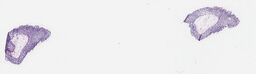

In [3]:
import large_image

ts = large_image.open('TCGA-AA-A02O-11A-01-BS1.svs')
# The thumbnail method returns a tuple with an image or numpy array and a mime type
ts.getThumbnail()[0]

In [4]:
# Every image's dimensions are in `sizeX` and `sizeY`.  If known, a variety of other information
# is provided.
ts.metadata

{'levels': 9,
 'sizeX': 55988,
 'sizeY': 16256,
 'tileWidth': 256,
 'tileHeight': 256,
 'magnification': 20.0,
 'mm_x': 0.0004991,
 'mm_y': 0.0004991,
 'dtype': 'uint8',
 'bandCount': 4}

If you have ipyleaflet installed and are using JupyterLab, you can ask the system to proxy requests
to an internal tile server that allows you to view the image in a zoomable viewer.  There are more options
depending on your Jupyter configuration and whether it is running locally or remotely.  
Some environments need different proxy options, like Google CoLab.

If ipyleaflet isn't installed, inspecting a tile source will just show the thumbnail.

In [5]:
# Ask JupyterLab to locally proxy an internal tile server
import importlib.util

if importlib.util.find_spec('google') and importlib.util.find_spec('google.colab'):
    # colab intercepts localhost
    large_image.tilesource.jupyter.IPyLeafletMixin.JUPYTER_PROXY = 'https://localhost'
else:
    large_image.tilesource.jupyter.IPyLeafletMixin.JUPYTER_PROXY = True

# Look at our tile source
ts

Map(center=[8128.0, 27994.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

If you see a black border on the right and bottom, this is because the ipyleaflet viewer shows areas
outside the bounds of the image.  We could ask for the image to be served using PNG images so that those
areas are transparent

In [6]:
ts = large_image.open('TCGA-AA-A02O-11A-01-BS1.svs', encoding='PNG')
ts

Map(center=[8128.0, 27994.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

The IPyLeaflet map uses a bottom-up y, x coordinate system, not the top-down x, y coordinate system 
most image system use.  The rationale is that this is appropriate for geospatial maps with
latitude and longitude, but it doesn't carry over to pixel coordinates very well.  There are some
convenience functions to convert coordinates.

In [7]:
import ipyleaflet

# Get a reference to the IPyLeaflet Map
map = ts.iplmap
# to_map converts pixel coordinates to IPyLeaflet map coordinates.
# draw a rectangle that is wider than tall.
rectangle = ipyleaflet.Rectangle(bounds=(ts.to_map((0, 0)), ts.to_map((10000, 5000))))
map.add_layer(rectangle)
# draw another rectangle that is the size of the whole image.
rectangle = ipyleaflet.Rectangle(bounds=(ts.to_map((0, 0)), ts.to_map((ts.sizeX, ts.sizeY))))
map.add_layer(rectangle)
# show the map
map

Map(bottom=232.0, center=[8128.0, 27994.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

Geospatial Sources
------------------

For geospatial sources, the default viewer shows the image in context on a world map if an appropriate projection is used.

In [8]:
geots = large_image.open('TC_NG_SFBay_US_Geo_COG.tif', projection='EPSG:3857', encoding='PNG')
geots

Map(center=[37.752214941926994, -122.41877581711466], controls=(ZoomControl(options=['position', 'zoom_in_text…

Geospatial sources have additional metadata and thumbnails.

In [9]:
geots.metadata

{'levels': 15,
 'sizeX': 4194304,
 'sizeY': 4194304,
 'tileWidth': 256,
 'tileHeight': 256,
 'magnification': None,
 'mm_x': 1381.876143450579,
 'mm_y': 1381.876143450579,
 'dtype': 'uint8',
 'bandCount': 3,
 'geospatial': True,
 'sourceLevels': 6,
 'sourceSizeX': 4323,
 'sourceSizeY': 4323,
 'bounds': {'ll': {'x': -13660993.43811085, 'y': 4502326.297712617},
  'ul': {'x': -13660993.43811085, 'y': 4586806.951318035},
  'lr': {'x': -13594198.136883384, 'y': 4502326.297712617},
  'ur': {'x': -13594198.136883384, 'y': 4586806.951318035},
  'srs': 'epsg:3857',
  'xmin': -13660993.43811085,
  'xmax': -13594198.136883384,
  'ymin': 4502326.297712617,
  'ymax': 4586806.951318035},
 'projection': 'epsg:3857',
 'sourceBounds': {'ll': {'x': -122.71879201711467, 'y': 37.45219874192699},
  'ul': {'x': -122.71879201711467, 'y': 38.052231141926995},
  'lr': {'x': -122.11875961711466, 'y': 37.45219874192699},
  'ur': {'x': -122.11875961711466, 'y': 38.052231141926995},
  'srs': '+proj=longlat +datum=

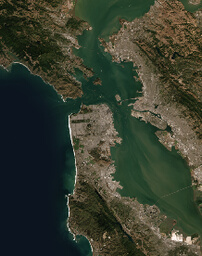

In [10]:
geots.getThumbnail()[0]

Girder Server Sources
---------------------

You can use files on a Girder server by just download them and using them locally.
However, you can use girder client to access files more conveniently.  If the Girder server
doesn't have the large_image plugin installed on it, this can still be useful -- functionally,
this pulls the file and provides a local tile server, so some of this requires the same
proxy setup as a local file.

`large_image.tilesource.jupyter.Map` is a convenience class that can use a variety of remote sources.

**(1)** We can get a source from girder via item or file id

In [11]:
import girder_client

gc1 = girder_client.GirderClient(apiUrl='https://data.kitware.com/api/v1')
# If you need to authenticate, an easy way is to ask directly
# gc.authenticate(interactive=True)
# but you could also use an API token or a variety of other methods.

# We can ask for the image by item or file id
map1 = large_image.tilesource.jupyter.Map(gc=gc1, id='57b345d28d777f126827dc28')
map1

Map(center=[6917.5, 15936.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

**(2)** We could use a resource path instead of an id

In [12]:
map2 = large_image.tilesource.jupyter.Map(gc=gc1, resource='/collection/HistomicsTK/CI and tox Test Data/large_image test files/Huron.Image2_JPEG2K.tif')
map2

Map(center=[5636.5, 4579.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [13]:
# You can get an id of an item using pure girder client calls, too.  For instance, internally, the
# id is fetched from the resource path and then used.
resourceFromMap2 = '/collection/HistomicsTK/CI and tox Test Data/large_image test files/Huron.Image2_JPEG2K.tif'
idOfResource = gc1.get('resource/lookup', parameters={'path': resourceFromMap2})['_id']
idOfResource

'5818e9418d777f10f26ee443'

**(3)** We can use a girder server that has the large_image plugin enabled.  This lets us do more than
just look at the image.

In [14]:
gc2 = girder_client.GirderClient(apiUrl='https://demo.kitware.com/histomicstk/api/v1')

resourcePath = '/collection/Crowd Source Paper/All slides/TCGA-A1-A0SP-01Z-00-DX1.20D689C6-EFA5-4694-BE76-24475A89ACC0.svs'
map3 = large_image.tilesource.jupyter.Map(gc=gc2, resource=resourcePath)
map3

Map(center=[45252.0, 54717.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [15]:
# We can check the metadata
map3.metadata

{'dtype': 'uint8',
 'levels': 10,
 'magnification': 40.0,
 'mm_x': 0.0002521,
 'mm_y': 0.0002521,
 'sizeX': 109434,
 'sizeY': 90504,
 'tileHeight': 256,
 'tileWidth': 256}

We can get data as a numpy array.

In [16]:
import pickle

pickle.loads(gc2.get(f'item/{map3.id}/tiles/region', parameters={'encoding': 'pickle', 'width': 100, 'height': 100},  jsonResp=False).content)


array([[[240, 242, 241, 255],
        [240, 242, 241, 255],
        [241, 242, 242, 255],
        ...,
        [238, 240, 239, 253],
        [239, 241, 240, 255],
        [239, 241, 240, 255]],

       [[240, 241, 240, 255],
        [239, 241, 240, 255],
        [240, 241, 240, 255],
        ...,
        [237, 238, 238, 253],
        [237, 239, 238, 255],
        [237, 239, 238, 255]],

       [[239, 241, 240, 255],
        [239, 241, 240, 255],
        [239, 241, 240, 255],
        ...,
        [236, 238, 237, 253],
        [237, 239, 238, 255],
        [237, 239, 238, 255]],

       ...,

       [[240, 241, 241, 255],
        [240, 241, 241, 255],
        [240, 241, 241, 255],
        ...,
        [239, 240, 239, 253],
        [240, 241, 240, 255],
        [239, 241, 240, 255]],

       [[241, 243, 242, 255],
        [241, 242, 242, 255],
        [241, 242, 242, 255],
        ...,
        [238, 241, 240, 253],
        [239, 242, 241, 255],
        [239, 241, 241, 255]],

       [[237

**(4)** From a metadata dictionary and a url.  Any slippy-map style tile server could be used.

In [17]:
# There can be additional items in the metadata, but this is minimum required.
remoteMetadata = {
  'levels': 10,
  'sizeX': 95758,
  'sizeY': 76873,
  'tileHeight': 256,
  'tileWidth': 256,
}
remoteUrl = 'https://demo.kitware.com/histomicstk/api/v1/item/5bbdeec6e629140048d01bb9/tiles/zxy/{z}/{x}/{y}?encoding=PNG'

map4 = large_image.tilesource.jupyter.Map(metadata=remoteMetadata, url=remoteUrl)
map4

Map(center=[38436.5, 47879.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…